In [1]:
import random
from dataclasses import dataclass
from collections import deque, namedtuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

NUM_EPISODES        = 1500
MAX_STEPS_PER_EP    = 200

GAMMA               = 0.99
LR                  = 1e-3
BATCH_SIZE          = 128
REPLAY_CAPACITY     = 50_000

EPS_START           = 1.0
EPS_END             = 0.05
EPS_DECAY_EPISODES  = 900

TARGET_UPDATE_FREQ  = 25
GRAD_CLIP           = 1.0

TRAINING_HISTORY_CSV = "portbrain_v2_training_history.csv"


Device: cpu


In [2]:
@dataclass
class Ship:
    ship_type: int
    cargo: float
    priority: float
    deadline: int
    tide_sensitive: int
    arrival_t: int
    waiting_t: int = 0


In [3]:
class PortEnvV2:
    def __init__(self,
                 B=3,
                 C=6,
                 ship_types=3,
                 K=5,
                 arrival_rate=1.4,
                 tide_period=30,
                 tide_open_frac=0.4,
                 max_queue=30,
                 max_steps=MAX_STEPS_PER_EP):

        self.B = B
        self.C = C
        self.ship_types = ship_types
        self.K = K
        self.arrival_rate = arrival_rate
        self.tide_period = tide_period
        self.tide_open_frac = tide_open_frac
        self.max_queue = max_queue
        self.max_steps = max_steps

        self.compat = np.array([
            [1, 1, 0],
            [1, 0, 1],
            [1, 1, 1],
        ], dtype=np.int32)

        if self.compat.shape != (B, ship_types):
            self.compat = (np.random.rand(B, ship_types) > 0.3).astype(np.int32)
            for t in range(ship_types):
                if self.compat[:, t].sum() == 0:
                    self.compat[np.random.randint(0, B), t] = 1

        self.base_rate = 0.8
        self.crane_rate = 0.6

        self.crane_options = [1, 2, 3]
        self.action_dim = self.B * self.K * len(self.crane_options) + 1

        self.state_dim = 5*self.B + 6*self.K + 6

        self.reset()

    def _tide_open(self, t):
        phase = (t % self.tide_period) / self.tide_period
        return 1 if phase < self.tide_open_frac else 0

    def _tide_feats(self, t):
        ang = 2*np.pi*(t % self.tide_period)/self.tide_period
        return np.sin(ang), np.cos(ang)

    def _spawn_ship(self, t):
        ship_type = np.random.randint(0, self.ship_types)
        cargo = float(np.random.uniform(6, 18))
        priority = float(np.random.choice([1.0, 1.5, 2.0]))
        deadline = t + int(np.random.randint(10, 35))
        tide_sensitive = int(np.random.rand() < 0.35)
        return Ship(ship_type, cargo, priority, deadline, tide_sensitive, arrival_t=t)

    def reset(self):
        self.t = 0
        self.queue = deque()
        self.done = False

        self.berths = []
        for _ in range(self.B):
            self.berths.append({
                "occupied": 0,
                "ship": None,
                "remaining_work": 0.0,
                "cranes": 0,
                "time_in_service": 0,
            })

        initial_n = np.random.randint(6, 14)
        for _ in range(initial_n):
            if len(self.queue) < self.max_queue:
                self.queue.append(self._spawn_ship(self.t))

        self.total_wait_time = 0.0
        self.total_ships_served = 0
        self.deadline_misses = 0
        self.total_arrivals = initial_n
        self.util_steps = 0

        return self._obs()

    def _obs(self):
        def norm(x, lo, hi):
            return float(np.clip((x - lo) / (hi - lo + 1e-9), 0.0, 1.0))

        obs = []

        for b in range(self.B):
            slot = self.berths[b]
            occ = slot["occupied"]
            obs.append(float(occ))
            if occ:
                ship = slot["ship"]
                obs.append(norm(ship.ship_type, 0, self.ship_types-1))
                obs.append(norm(slot["remaining_work"], 0, 25))
                obs.append(norm(slot["cranes"], 0, self.C))
                obs.append(norm(slot["time_in_service"], 0, self.max_steps))
            else:
                obs.extend([0.0, 0.0, 0.0, 0.0])

        tide_open = self._tide_open(self.t)
        for i in range(self.K):
            if i < len(self.queue):
                sh = self.queue[i]
                slack = sh.deadline - self.t
                obs.append(norm(sh.ship_type, 0, self.ship_types-1))
                obs.append(norm(sh.cargo, 0, 25))
                obs.append(norm(sh.priority, 1.0, 2.0))
                obs.append(norm(slack, -20, 40))
                obs.append(norm(sh.waiting_t, 0, 60))
                obs.append(float(sh.tide_sensitive))
            else:
                obs.extend([0.0]*6)

        cranes_used = sum(slot["cranes"] for slot in self.berths)
        cranes_free = self.C - cranes_used
        s_tide, c_tide = self._tide_feats(self.t)

        obs.append(norm(len(self.queue), 0, self.max_queue))
        obs.append(norm(cranes_free, 0, self.C))
        obs.append(float(tide_open))
        obs.append(float((s_tide+1)/2))
        obs.append(float((c_tide+1)/2))
        obs.append(norm(self.t, 0, self.max_steps))

        return np.array(obs, dtype=np.float32)

    def _decode_action(self, a):
        if a == self.action_dim - 1:
            return None
        per_berth = self.K * len(self.crane_options)
        berth_id = a // per_berth
        rem = a % per_berth
        q_idx = rem // len(self.crane_options)
        c_idx = rem % len(self.crane_options)
        cranes = self.crane_options[c_idx]
        return berth_id, q_idx, cranes

    def step(self, action):
        if self.done:
            raise ValueError("Episode done. Call reset().")

        info = {}
        reward = 0.0

        decoded = self._decode_action(int(action))
        cranes_used = sum(slot["cranes"] for slot in self.berths)
        cranes_free = self.C - cranes_used
        tide_open = self._tide_open(self.t)

        scheduled = 0
        infeasible = 0

        if decoded is not None:
            b, q_idx, cranes = decoded
            slot = self.berths[b]

            if slot["occupied"] == 1:
                infeasible = 1
            elif q_idx >= len(self.queue):
                infeasible = 1
            elif cranes > cranes_free:
                infeasible = 1
            else:
                ship = self.queue[q_idx]
                if self.compat[b, ship.ship_type] == 0:
                    infeasible = 1
                if ship.tide_sensitive == 1 and tide_open == 0:
                    infeasible = 1

            if infeasible == 0:
                ship = self.queue[q_idx]
                del self.queue[q_idx]
                slot["occupied"] = 1
                slot["ship"] = ship
                slot["remaining_work"] = ship.cargo
                slot["cranes"] = cranes
                slot["time_in_service"] = 0
                scheduled = 1

        reward -= 2.0 * infeasible

        served_now = 0
        for slot in self.berths:
            if slot["occupied"] == 1:
                slot["time_in_service"] += 1
                rate = self.base_rate + self.crane_rate * slot["cranes"]
                slot["remaining_work"] -= rate
                self.util_steps += 1

                if slot["remaining_work"] <= 0:
                    ship = slot["ship"]
                    served_now += 1
                    self.total_ships_served += 1

                    reward += 8.0 * ship.priority

                    if self.t > ship.deadline:
                        self.deadline_misses += 1
                        reward -= 6.0 * ship.priority

                    slot["occupied"] = 0
                    slot["ship"] = None
                    slot["remaining_work"] = 0.0
                    slot["cranes"] = 0
                    slot["time_in_service"] = 0

        reward += 2.0 * served_now

        wait_pen = 0.0
        deadline_pen = 0.0
        for sh in self.queue:
            sh.waiting_t += 1
            self.total_wait_time += 1
            wait_pen += 0.15 * sh.priority
            if self.t > sh.deadline:
                deadline_pen += 0.25 * sh.priority

        reward -= wait_pen
        reward -= deadline_pen
        reward -= 0.05

        arrivals = np.random.poisson(self.arrival_rate)
        arrivals_added = 0
        for _ in range(arrivals):
            if len(self.queue) < self.max_queue:
                self.queue.append(self._spawn_ship(self.t))
                arrivals_added += 1

        self.total_arrivals += arrivals_added

        self.t += 1
        if self.t >= self.max_steps:
            self.done = True

        cranes_used_after = sum(slot["cranes"] for slot in self.berths)
        info.update({
            "t": self.t,
            "scheduled": scheduled,
            "infeasible": infeasible,
            "served_now": served_now,
            "queue_len": len(self.queue),
            "arrivals": arrivals_added,
            "cranes_used": cranes_used_after,
            "tide_open": tide_open,
            "deadline_misses": self.deadline_misses,
            "total_served": self.total_ships_served,
        })

        return self._obs(), float(reward), self.done, info


In [4]:
Transition = namedtuple("Transition", ("state","action","reward","next_state","done"))

class ReplayMemory:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def push(self, *args):
        self.buf.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.buf, batch_size)
    def __len__(self):
        return len(self.buf)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.action_dim = action_dim
        self.policy = DQN(state_dim, action_dim).to(device)
        self.target = DQN(state_dim, action_dim).to(device)
        self.target.load_state_dict(self.policy.state_dict())
        self.target.eval()

        self.opt = optim.Adam(self.policy.parameters(), lr=LR)
        self.mem = ReplayMemory(REPLAY_CAPACITY)

    def epsilon(self, ep):
        frac = min(1.0, ep / EPS_DECAY_EPISODES)
        return EPS_START + frac * (EPS_END - EPS_START)

    def act(self, state, ep):
        eps = self.epsilon(ep)
        if random.random() < eps:
            return random.randrange(self.action_dim)
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q = self.policy(s)
        return int(torch.argmax(q, dim=1).item())

    def optimize(self):
        if len(self.mem) < BATCH_SIZE:
            return None

        batch = Transition(*zip(*self.mem.sample(BATCH_SIZE)))

        s  = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=device)
        a  = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
        r  = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
        ns = torch.tensor(np.stack(batch.next_state), dtype=torch.float32, device=device)
        d  = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

        q_sa = self.policy(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target(ns).max(1, keepdim=True)[0]
            y = r + GAMMA * q_next * (1.0 - d)

        loss = nn.SmoothL1Loss()(q_sa, y)

        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), GRAD_CLIP)
        self.opt.step()
        return float(loss.item())

    def update_target(self):
        self.target.load_state_dict(self.policy.state_dict())


In [5]:
env = PortEnvV2(B=3, C=6, ship_types=3, K=5, arrival_rate=1.4, max_steps=MAX_STEPS_PER_EP)
agent = DQNAgent(env.state_dim, env.action_dim)

history = []
best = -1e18

print(f"State dim: {env.state_dim} | Action dim: {env.action_dim}")

for ep in trange(NUM_EPISODES, desc="Training V2"):
    s = env.reset()
    total_r = 0.0
    losses = []
    infeasible_cnt = 0

    for _ in range(MAX_STEPS_PER_EP):
        a = agent.act(s, ep)
        ns, r, done, info = env.step(a)

        total_r += r
        infeasible_cnt += info["infeasible"]

        agent.mem.push(s, a, r, ns, float(done))
        loss = agent.optimize()
        if loss is not None:
            losses.append(loss)

        s = ns
        if done:
            break

    if (ep+1) % TARGET_UPDATE_FREQ == 0:
        agent.update_target()

    eps = agent.epsilon(ep)
    avg_loss = float(np.mean(losses)) if losses else 0.0

    steps = info["t"]
    util = env.util_steps / max(1, env.B * steps)

    avg_wait = env.total_wait_time / max(1, env.total_arrivals)
    miss_rate = env.deadline_misses / max(1, env.total_ships_served)

    row = {
        "episode": ep+1,
        "reward": total_r,
        "steps": steps,
        "epsilon": eps,
        "avg_loss": avg_loss,
        "served": env.total_ships_served,
        "arrivals": env.total_arrivals,
        "avg_wait": avg_wait,
        "deadline_miss_rate": miss_rate,
        "utilization": util,
        "infeasible_actions": infeasible_cnt,
    }
    history.append(row)

    if total_r > best:
        best = total_r

    if (ep+1) % 50 == 0:
        print(f"\n[Ep {ep+1}] R={total_r:8.2f} | served={env.total_ships_served:3d} | "
              f"avg_wait={avg_wait:5.2f} | miss_rate={miss_rate:4.2f} | util={util:4.2f} | "
              f"infeas={infeasible_cnt:3d} | eps={eps:0.3f}")

df = pd.DataFrame(history)
df.to_csv(TRAINING_HISTORY_CSV, index=False)
print("Saved:", TRAINING_HISTORY_CSV)

df.head()


State dim: 51 | Action dim: 46


Training V2:   3%|▎         | 50/1500 [00:29<14:14,  1.70it/s]


[Ep 50] R=-2941.70 | served= 52 | avg_wait=68.89 | miss_rate=0.92 | util=0.60 | infeas=147 | eps=0.948


Training V2:   7%|▋         | 100/1500 [00:58<13:40,  1.71it/s]


[Ep 100] R=-3019.08 | served= 48 | avg_wait=74.77 | miss_rate=0.90 | util=0.53 | infeas=148 | eps=0.895


Training V2:  10%|█         | 150/1500 [01:28<13:33,  1.66it/s]


[Ep 150] R=-3106.03 | served= 45 | avg_wait=75.72 | miss_rate=0.93 | util=0.48 | infeas=148 | eps=0.843


Training V2:  13%|█▎        | 200/1500 [01:59<14:21,  1.51it/s]


[Ep 200] R=-2728.30 | served= 49 | avg_wait=70.91 | miss_rate=0.92 | util=0.59 | infeas=144 | eps=0.790


Training V2:  17%|█▋        | 250/1500 [02:35<14:04,  1.48it/s]


[Ep 250] R=-2621.12 | served= 54 | avg_wait=64.82 | miss_rate=0.89 | util=0.61 | infeas=136 | eps=0.737


Training V2:  20%|██        | 300/1500 [03:11<13:23,  1.49it/s]


[Ep 300] R=-2894.88 | served= 51 | avg_wait=70.41 | miss_rate=0.88 | util=0.56 | infeas=143 | eps=0.684


Training V2:  23%|██▎       | 350/1500 [03:51<13:47,  1.39it/s]


[Ep 350] R=-2876.55 | served= 47 | avg_wait=72.31 | miss_rate=0.85 | util=0.49 | infeas=144 | eps=0.632


Training V2:  27%|██▋       | 400/1500 [04:27<13:13,  1.39it/s]


[Ep 400] R=-2876.58 | served= 52 | avg_wait=69.50 | miss_rate=0.90 | util=0.63 | infeas=140 | eps=0.579


Training V2:  30%|███       | 450/1500 [05:04<12:56,  1.35it/s]


[Ep 450] R=-2867.25 | served= 50 | avg_wait=69.09 | miss_rate=0.90 | util=0.54 | infeas=140 | eps=0.526


Training V2:  33%|███▎      | 500/1500 [05:40<12:02,  1.38it/s]


[Ep 500] R=-2464.23 | served= 59 | avg_wait=63.38 | miss_rate=0.90 | util=0.67 | infeas=135 | eps=0.473


Training V2:  37%|███▋      | 550/1500 [06:16<11:49,  1.34it/s]


[Ep 550] R=-2978.07 | served= 49 | avg_wait=71.74 | miss_rate=0.88 | util=0.53 | infeas=140 | eps=0.420


Training V2:  40%|████      | 600/1500 [06:52<10:22,  1.45it/s]


[Ep 600] R=-2704.12 | served= 56 | avg_wait=64.92 | miss_rate=0.88 | util=0.60 | infeas=130 | eps=0.368


Training V2:  43%|████▎     | 650/1500 [07:47<21:43,  1.53s/it]


[Ep 650] R=-2841.95 | served= 48 | avg_wait=72.81 | miss_rate=0.94 | util=0.53 | infeas=140 | eps=0.315


Training V2:  47%|████▋     | 700/1500 [08:41<09:12,  1.45it/s]


[Ep 700] R=-2480.72 | served= 52 | avg_wait=65.74 | miss_rate=0.92 | util=0.63 | infeas=124 | eps=0.262


Training V2:  50%|█████     | 750/1500 [09:16<08:39,  1.44it/s]


[Ep 750] R=-2673.90 | served= 53 | avg_wait=67.60 | miss_rate=0.87 | util=0.62 | infeas=131 | eps=0.209


Training V2:  53%|█████▎    | 800/1500 [09:50<08:12,  1.42it/s]


[Ep 800] R=-2678.75 | served= 56 | avg_wait=64.20 | miss_rate=0.88 | util=0.69 | infeas=133 | eps=0.157


Training V2:  57%|█████▋    | 850/1500 [10:27<08:43,  1.24it/s]


[Ep 850] R=-2482.23 | served= 62 | avg_wait=59.85 | miss_rate=0.90 | util=0.65 | infeas=122 | eps=0.104


Training V2:  60%|██████    | 900/1500 [11:05<07:32,  1.33it/s]


[Ep 900] R=-2517.55 | served= 48 | avg_wait=67.49 | miss_rate=0.85 | util=0.51 | infeas=132 | eps=0.051


Training V2:  63%|██████▎   | 950/1500 [11:42<07:20,  1.25it/s]


[Ep 950] R=-2598.47 | served= 60 | avg_wait=62.68 | miss_rate=0.88 | util=0.61 | infeas=133 | eps=0.050


Training V2:  67%|██████▋   | 1000/1500 [12:20<06:04,  1.37it/s]


[Ep 1000] R=-2541.27 | served= 56 | avg_wait=64.35 | miss_rate=0.89 | util=0.64 | infeas=109 | eps=0.050


Training V2:  70%|███████   | 1050/1500 [12:59<05:45,  1.30it/s]


[Ep 1050] R=-2615.80 | served= 55 | avg_wait=66.08 | miss_rate=0.93 | util=0.61 | infeas=131 | eps=0.050


Training V2:  73%|███████▎  | 1100/1500 [13:37<05:09,  1.29it/s]


[Ep 1100] R=-2646.40 | served= 50 | avg_wait=68.26 | miss_rate=0.86 | util=0.53 | infeas=132 | eps=0.050


Training V2:  77%|███████▋  | 1150/1500 [14:18<04:35,  1.27it/s]


[Ep 1150] R=-2434.00 | served= 63 | avg_wait=59.30 | miss_rate=0.86 | util=0.71 | infeas=111 | eps=0.050


Training V2:  80%|████████  | 1200/1500 [14:57<03:51,  1.30it/s]


[Ep 1200] R=-2437.65 | served= 58 | avg_wait=64.67 | miss_rate=0.86 | util=0.59 | infeas=135 | eps=0.050


Training V2:  83%|████████▎ | 1250/1500 [15:37<03:28,  1.20it/s]


[Ep 1250] R=-2482.22 | served= 57 | avg_wait=63.39 | miss_rate=0.96 | util=0.62 | infeas=123 | eps=0.050


Training V2:  87%|████████▋ | 1300/1500 [16:12<02:20,  1.42it/s]


[Ep 1300] R=-2594.68 | served= 59 | avg_wait=63.63 | miss_rate=0.90 | util=0.64 | infeas=135 | eps=0.050


Training V2:  90%|█████████ | 1350/1500 [16:49<01:59,  1.26it/s]


[Ep 1350] R=-2897.05 | served= 46 | avg_wait=73.88 | miss_rate=0.83 | util=0.53 | infeas=135 | eps=0.050


Training V2:  93%|█████████▎| 1400/1500 [17:28<01:15,  1.32it/s]


[Ep 1400] R=-2674.93 | served= 52 | avg_wait=67.75 | miss_rate=0.88 | util=0.61 | infeas=118 | eps=0.050


Training V2:  97%|█████████▋| 1450/1500 [18:06<00:39,  1.26it/s]


[Ep 1450] R=-2608.23 | served= 54 | avg_wait=68.95 | miss_rate=0.93 | util=0.51 | infeas=139 | eps=0.050


Training V2: 100%|██████████| 1500/1500 [18:43<00:00,  1.34it/s]


[Ep 1500] R=-2815.27 | served= 46 | avg_wait=74.47 | miss_rate=0.83 | util=0.50 | infeas=142 | eps=0.050
Saved: portbrain_v2_training_history.csv


,episode,reward,steps,epsilon,avg_loss,served,arrivals,avg_wait,deadline_miss_rate,utilization,infeasible_actions
0,1,-2893.075,200,1.000000,5.317249,40,70,83.214286,0.925000,0.530000,158
1,2,-2842.975,200,0.998944,0.902474,39,70,82.685714,0.871795,0.486667,155
2,3,-3310.650,200,0.997889,0.602842,33,65,88.476923,0.939394,0.436667,159
3,4,-2857.900,200,0.996833,0.620898,52,83,70.036145,0.826923,0.603333,144
4,5,-2719.225,200,0.995778,0.628749,43,73,77.534247,0.906977,0.536667,156


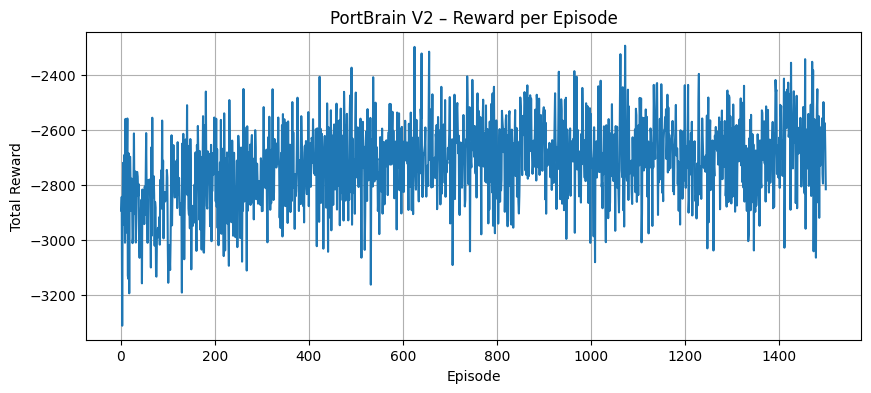

In [6]:
plt.figure(figsize=(10,4))
plt.plot(df["episode"], df["reward"])
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PortBrain V2 – Reward per Episode")
plt.grid(True)
plt.show()

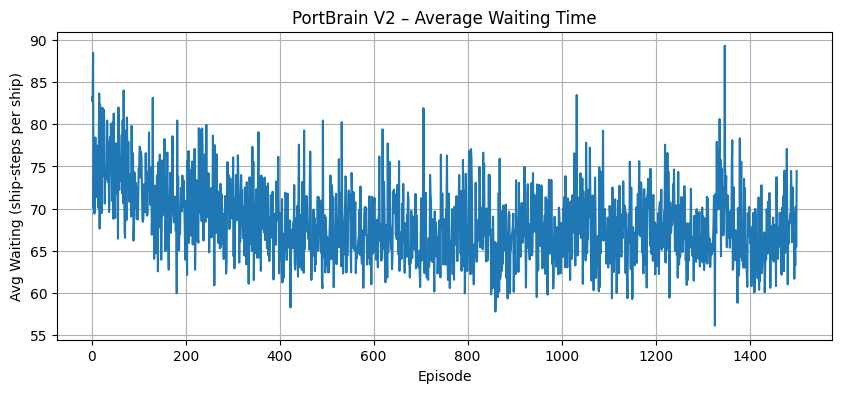

In [7]:
plt.figure(figsize=(10,4))
plt.plot(df["episode"], df["avg_wait"])
plt.xlabel("Episode")
plt.ylabel("Avg Waiting (ship-steps per ship)")
plt.title("PortBrain V2 – Average Waiting Time")
plt.grid(True)
plt.show()

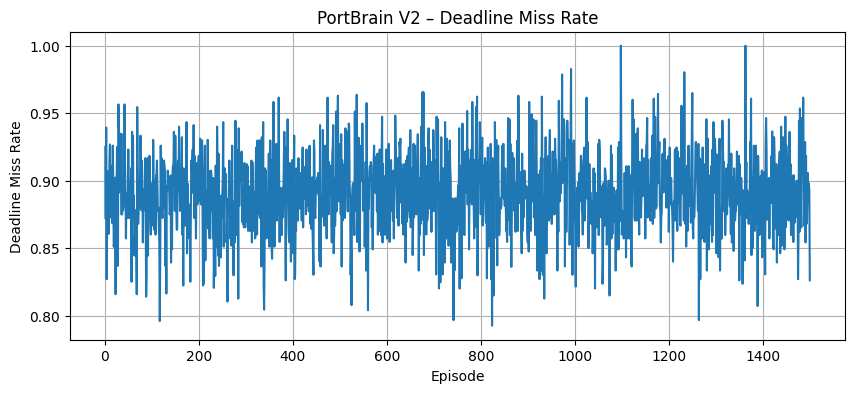

In [8]:
plt.figure(figsize=(10,4))
plt.plot(df["episode"], df["deadline_miss_rate"])
plt.xlabel("Episode")
plt.ylabel("Deadline Miss Rate")
plt.title("PortBrain V2 – Deadline Miss Rate")
plt.grid(True)
plt.show()

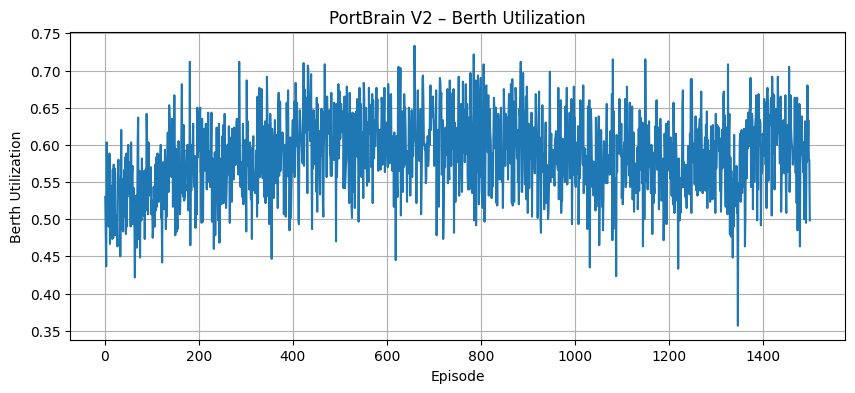

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df["episode"], df["utilization"])
plt.xlabel("Episode")
plt.ylabel("Berth Utilization")
plt.title("PortBrain V2 – Berth Utilization")
plt.grid(True)
plt.show()